In [1]:
using PyCall # to use numpy
using DataFrames # to manipulate dataset like pandas
using CSV # to import dataset
using MLDataUtils # to split dataset
using ScikitLearn 
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using Base.Iterators: partition
using IterTools: ncycle
using Parameters: @with_kw
using Plots 
@sk_import preprocessing: (LabelBinarizer, StandardScaler) # for scaling

PyObject <class 'sklearn.preprocessing._data.StandardScaler'>

importing dataset,
where the output of CSV.FIle is something the DataFrame type has defined a constructor for.

In [ ]:
df = DataFrame(CSV.File("Churn_Modelling.csv"))

replace values: better to use onehot encoder

In [3]:
for itr in 1:size(df, 1)

    # gender Male = 0, Female = 1
    if df[itr, "Gender"] == "Male"
        df[itr, "Gender"] = replace(df[itr, "Gender"], "Male" => 0)
        # replace values must be the same. Ex) "Male" => 0 this is we want, but if "M" => 0, then we get "ale"
    else
        df[itr, "Gender"] = replace(df[itr, "Gender"], "Female" =>  1)
    end

    # ['France' 'Spain' 'Germany'] = 0, 1, 2
    if df[itr, "Geography"] == "France"
        df[itr, "Geography"] = replace(df[itr, "Geography"], "France" => 0)

    elseif df[itr, "Geography"] == "Spain"
        df[itr, "Geography"] = replace(df[itr, "Geography"], "Spain" => 1)

    else
        df[itr, "Geography"] = replace(df[itr, "Geography"], "Germany" => 2)
    end
end

convert dataframe types to Int64

In [ ]:
df.Gender = parse.(Int, df.Gender)
df.Geography = parse.(Int, df.Geography)

# extract dataset into x and y
data_x = df[:, 4:end-1] # return as dataframe
data_y = df[:, end] # return as Vector

spliting dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = splitobs((data_x, data_y); at = 0.80) # need dataframe: y_train (8000, 1)

Scaling dataset as deep leaning needs (as values are so different)

In [ ]:
x_train = convert(Array{Float64}, x_train[:, :]) # (8000, 10) 8000 features with 10 row atm
x_test = convert(Array{Float64}, x_test[:, :]) 

sc = StandardScaler() # no differences between Python and Julia (return values)
 
x_train = sc.fit_transform(x_train) # (8000, 10)
x_test = sc.transform(x_test)

Sampling

In [ ]:
# sample neural networks with 1 row
sample_x = x_train[1, :]
layer1 = Dense(10, 6, relu) # assume 1 row (10 features) are going to a layer

println("Sample Row")
println(sample_x) # original values

println("\nlayer 1 and relu")
println(layer1(sample_x)) # calculated with relu -> y = max(0, x)

layer2 = Dense(6, 6, relu)
println("\nlayer 1, 2 and relu")
println(layer2(layer1(sample_x))) # calculated with relu -> y = max(0, x)

layer3 = Dense(6, 1, σ)
println("\nlayer 1, 2 and 3 with Sigmoid")

pred = layer3(layer2(layer1(sample_x)))
println(pred) # calculated with relu -> y = max(0, x)

println("\nActual value is ")
println(y_train[1, :])

threshold = 0.5 

if pred[1] > threshold
    println("Predict is 1")
    println(pred[1])
else
    println("Predict is 0")
    println(pred[1])
end 

sample_loss = Flux.Losses.binarycrossentropy(pred, y_train[1, :])
println("\nsample_loss is (binarycrossentropy in layer1-3)")
println(sample_loss)

building ANN model

In [8]:
model = Flux.Chain(
    Dense(10, 6, relu), # 10 features (columns) are coming in, 6 are for hiding layer -> 10*6 table + 6 biases
    Dense(6, 6, relu), # 6 features in, 6 features out with relu
    Dense(6, 1, σ) # output layer
    # >| GPU 
    )

Chain(Dense(10, 6, relu), Dense(6, 6, relu), Dense(6, 1, σ))

Data Preparation ------------------------------

In [9]:
x_train = transpose(x_train) # (10, 8000) 10 features with 8000 rows  
y_train = transpose(y_train) # (1, 8000) when x_train tranposed, y must do if as they 1 to 1 mapping

x_test = transpose(x_test)
y_test = transpose(y_test)

train_data = DataLoader((x_train, y_train), batchsize=32, shuffle=true) # 250 blocks
test_data = DataLoader((x_test, y_test), batchsize=10) # 200 blocks

DataLoader{Tuple{LinearAlgebra.Transpose{Float64, Matrix{Float64}}, LinearAlgebra.Transpose{Int64, SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}}}}(([0.9998152967395256 0.5867554230344194 … 1.257977717805217 1.46450765465777; 1.5101651784435293 0.30384251967685577 … 1.5101651784435293 -0.9024801390898175; … ; 0.9750608806857385 -1.0255769868407831 … -1.0255769868407831 -1.0255769868407831; 1.399416744939594 0.45683267007459294 … -0.12708652513080257 -1.0780140735845467], [0 0 … 1 0]), 10, 2000, true, 2000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000], false)

Optimizer ------------------------------

In [10]:
lr = 0.001 # learning_rate
opt = ADAM(lr, (0.9, 0.999)) 

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

Loss and Accuracy ------------------------------

In [11]:
loss(x, y) = Flux.Losses.binarycrossentropy(model(x), y) # when this loss is called, assume x and y are given from training 
accuracy(x, y) = mean(argmax(model(x)) .== argmax(y)) # when this accuracy is called, assume x and y are given from training

train_losses = []
test_losses = []
train_acces = []
test_acces = []

Any[]

Callbacks ------------------------------

In [12]:
function loss_all(data_loader)
    sum([loss(x, y) for (x,y) in data_loader]) / length(data_loader) 
end

function acc(data_loader) # need to fix the values
    acc = 0
    for (x,y) in data_loader
        values = model(x) # if GPU is on, cpu(model(x))
        guesses = [v[1] > 0.5 ? 1 : 0 for v ∈ values]
        acc += sum(guesses .== y) * 1 / size(x, 2)
        # acc += sum(guesses .== cpu(y)) * 1 / size(x, 2) # GPU is on
    end
    acc/length(data_loader)
end

callbacks = [
    () -> push!(train_losses, loss_all(train_data)),
    () -> push!(test_losses, loss_all(test_data)),

    () -> push!(train_acces, acc(train_data)),
    () -> push!(test_acces, acc(test_data)),    
]


4-element Vector{Function}:
 #5 (generic function with 1 method)
 #6 (generic function with 1 method)
 #7 (generic function with 1 method)
 #8 (generic function with 1 method)

Training ------------------------------

In [13]:
epochs = 5
ps = Flux.params(model) # get the gradient of all parameters used in a program without explicitly passing them in

@epochs epochs Flux.train!(loss, ps, train_data, opt, cb = callbacks) #train!(loss, params, data, opt; cb)

@show train_loss = loss_all(train_data)
@show test_loss = loss_all(test_data)
@show train_acc = acc(train_data)
@show test_acc = acc(test_data)

┌ Info: Epoch 1
└ @ Main C:\Users\Yishi\.julia\packages\Flux\sY3yx\src\optimise\train.jl:136
┌ Info: Epoch 2
└ @ Main C:\Users\Yishi\.julia\packages\Flux\sY3yx\src\optimise\train.jl:136
┌ Info: Epoch 3
└ @ Main C:\Users\Yishi\.julia\packages\Flux\sY3yx\src\optimise\train.jl:136
┌ Info: Epoch 4
└ @ Main C:\Users\Yishi\.julia\packages\Flux\sY3yx\src\optimise\train.jl:136
┌ Info: Epoch 5
└ @ Main C:\Users\Yishi\.julia\packages\Flux\sY3yx\src\optimise\train.jl:136


train_loss = loss_all(train_data) = 0.4113274f0
test_loss = loss_all(test_data) = 0.42182294f0
train_acc = acc(train_data) = 0.83
test_acc = acc(test_data) = 0.8175000000000012


0.8175000000000012

Plotting ------------------------------

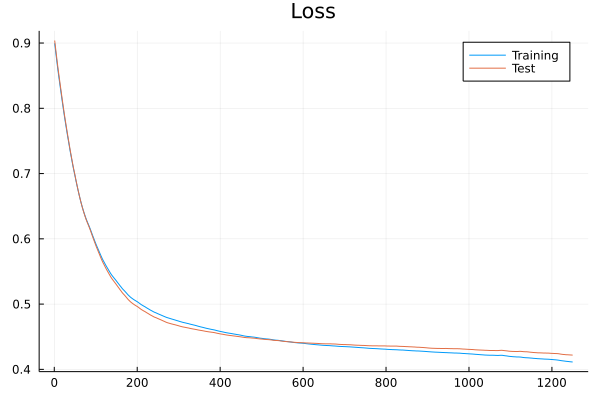

In [41]:
plot([train_losses, test_losses], title = "Loss", label = ["Training" "Test"])

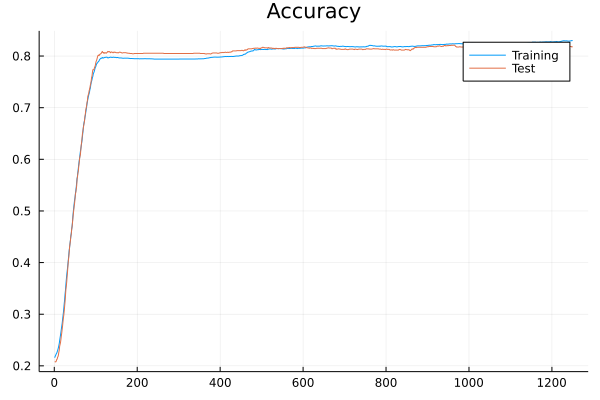

In [40]:
plot([train_acces, test_acces], title = "Accuracy", label = ["Training" "Test"])

Prediction ------------------------------

In [ ]:
pred_test = (model(x_test[:, 1]))

println("\nTest value is ")
println((y_test[:, 1]))

if pred_test[1] > threshold
    println("\nPredict is 1")
    println(pred_test[1])
else
    println("\nPredict is 0")
    println(pred_test[1])
end 

println("\nFinished")